In [1]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation,MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
# Create new variables to be used in Keras and the CNN

# number of items to use for training
BATCH_SIZE = 5 

# Number of identifying classes 
#   WE have two, Bloom and no bloom 1/0
NUM_CLASSES = 2 

# number of times to repeat process
EPOCHS = 100

In [3]:

# Load the data
df = pd.read_csv('../../data/cleaned/site1_malin.csv')
df.head()

,date (mm.dd.yyyy),Depth [m],T [deg C],DO [%],SPC [micro S/cm],NH4 [mg/l],NO3 [mg/l],PO4 [mg/l],Chl tot [micro g/l],Chl cyano [micro g/l],Chl green Al. [micro g/l],turb [FTU],Secci Depth [m],pH
0,6/1/2016,0.0,20.8,127.3,748,0.877326755,0.162558848,0.012251796,39.8,3.2,36.6,5.1,0.8,8.63
1,6/1/2016,0.5,20.8,127.0,748,-,-,-,55.4,3.7,51.7,4.8,-,8.65
2,6/1/2016,1.0,20.4,131.4,756,-,-,-,45.6,3.0,42.6,4.9,-,8.66
3,6/1/2016,2.0,18.0,85.4,775,-,-,-,41.0,3.9,37.1,5.0,-,8.25
4,6/1/2016,3.0,15.8,4.0,786,1.050011213,0.270562171,0.031263202,54.6,5.8,48.8,5.8,-,7.89


In [4]:
target = df['Chl cyano [micro g/l]'].apply(lambda x : 1 if x > 20 else 0)
dataset = df.drop(columns=['NH4 [mg/l]', 'NO3 [mg/l]', 'PO4 [mg/l]', 'Secci Depth [m]','Chl cyano [micro g/l]'])
dataset['bloom'] = target
dataset.head(5)

,date (mm.dd.yyyy),Depth [m],T [deg C],DO [%],SPC [micro S/cm],Chl tot [micro g/l],Chl green Al. [micro g/l],turb [FTU],pH,bloom
0,6/1/2016,0.0,20.8,127.3,748,39.8,36.6,5.1,8.63,0
1,6/1/2016,0.5,20.8,127.0,748,55.4,51.7,4.8,8.65,0
2,6/1/2016,1.0,20.4,131.4,756,45.6,42.6,4.9,8.66,0
3,6/1/2016,2.0,18.0,85.4,775,41.0,37.1,5.0,8.25,0
4,6/1/2016,3.0,15.8,4.0,786,54.6,48.8,5.8,7.89,0


In [5]:
from datetime import datetime

dataset['date (mm.dd.yyyy)'] = pd.to_datetime(dataset['date (mm.dd.yyyy)'])

#converts the date object to a numerical representation of that object
dataset['date (mm.dd.yyyy)'] = (dataset['date (mm.dd.yyyy)'] - dataset['date (mm.dd.yyyy)'].min()) / np.timedelta64(1,'D')
dataset.dtypes

date (mm.dd.yyyy)            float64
Depth [m]                    float64
T [deg C]                    float64
DO [%]                       float64
SPC [micro S/cm]               int64
Chl tot [micro g/l]          float64
Chl green Al. [micro g/l]    float64
turb [FTU]                   float64
pH                           float64
bloom                          int64
dtype: object

In [6]:
# lets try to normalize this now....
from sklearn.preprocessing import MinMaxScaler
dataset_columns = ['date (mm.dd.yyyy)','Depth [m]','T [deg C]', 'DO [%]','SPC [micro S/cm] ',
'Chl tot [micro g/l]','Chl green Al. [micro g/l]', 'turb [FTU]','pH ','bloom']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(dataset)
dataset = pd.DataFrame(ds_scaled,columns=dataset_columns)
dataset.describe()


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,date (mm.dd.yyyy),Depth [m],T [deg C],DO [%],SPC [micro S/cm],Chl tot [micro g/l],Chl green Al. [micro g/l],turb [FTU],pH,bloom
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.500000,0.433333,0.630545,0.577551,0.402597,0.332460,0.260335,0.137371,0.483394,0.300000
std,0.303492,0.360654,0.249957,0.205032,0.206691,0.190768,0.212422,0.176529,0.211168,0.460355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.238095,0.166667,0.556667,0.526077,0.219780,0.219836,0.107899,0.034502,0.316667,0.000000
50%,0.500000,0.333333,0.713333,0.590703,0.357143,0.279141,0.192182,0.059955,0.460000,0.000000
75%,0.761905,0.666667,0.771667,0.670068,0.571429,0.374233,0.333062,0.160633,0.680000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Functions to take a moving window of the data of 10 time stamps

In [7]:
'''
determines the window size for the daata set
@param dataset - The dataset to get windows for
@param window_size - the size of the window  
@param shift - the amout to shift the window
'''
def windows(dataset, window_size, shift):
    start = 0
    while start+window_size < dataset.shape[0]: 
        yield (int(start), int(start+window_size))
        # shift the window five blocks of time
        start += shift
        if start % 5 == 0:
            print('Window Segmentation {0:.2f}% done'.format(((start+window_size) / dataset.shape[0]) * 100 ))


'''

Segments the dataset based on the parameters that are passed in.
@param dataset - the dataset to segment into window
@param columns - the array of columns from the dataset to be looked at
@param window_size - the size of the window you would like to be looked at. Defualt is 10

'''
def segment_dataset(dataset, columns, target, window_size=10):    
    print('WINDOW SIZE',window_size)
    print('NUMBER OF COULUMNS',len(columns))
    segments = np.empty((0, window_size, len(columns)))
    labels = np.empty((0))
    count = 0
    for (start, end) in windows(dataset, window_size, 1):
        count+=1
        values = dataset[columns][start:end]
        if(values.shape[0] == window_size):
            segments = np.vstack([segments, np.stack([values])])
            # Takes the larger of the two variables if there are more than one. 
            # This makes it more likly to predict a bloom. Can be changed to iloc[0] to
            # be less likly to predict a bloom (more 0s in the label array)
            
            labels = np.append(labels, dataset[target][start:end].mode().iloc[-1])
        else:
            print("No more Windows available... Exiting")
            break
    return (segments, labels)

In [8]:
feature_columns = dataset_columns[:-1]
(segments, labels) = segment_dataset(dataset, feature_columns, 'bloom', 9)
print('done')

WINDOW SIZE 9
NUMBER OF COULUMNS 9
Window Segmentation 12.73% done
Window Segmentation 17.27% done
Window Segmentation 21.82% done
Window Segmentation 26.36% done
Window Segmentation 30.91% done
Window Segmentation 35.45% done
Window Segmentation 40.00% done
Window Segmentation 44.55% done
Window Segmentation 49.09% done
Window Segmentation 53.64% done
Window Segmentation 58.18% done
Window Segmentation 62.73% done
Window Segmentation 67.27% done
Window Segmentation 71.82% done
Window Segmentation 76.36% done
Window Segmentation 80.91% done
Window Segmentation 85.45% done
Window Segmentation 90.00% done
Window Segmentation 94.55% done
Window Segmentation 99.09% done
done


In [9]:
segments.shape

(101, 9, 9)

In [10]:
labels.shape

(101,)

In [11]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Shaping the data to be used in the model.

In [12]:
segments = segments.reshape(len(segments),9,9,1)
segments.shape

(101, 9, 9, 1)

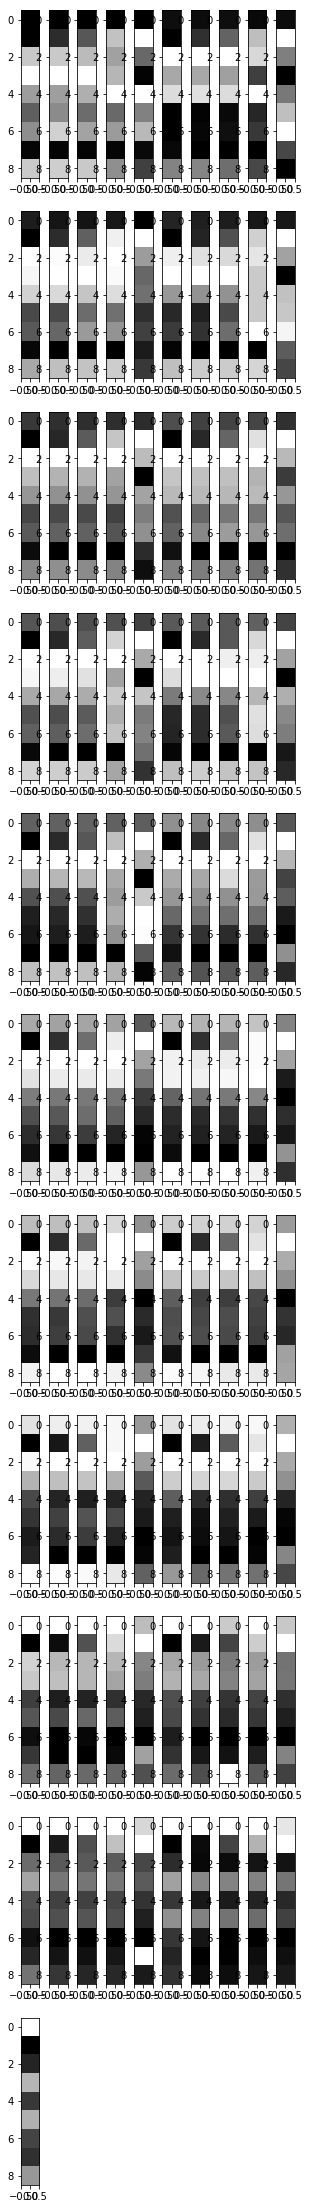

In [13]:
#what the heck does this look like now?
X = 5
y = 40
plt.figure(figsize=(X,y))
columns = 10
for x in range(0, segments.shape[0]):
    plt.subplot(len(segments) / columns + 1, columns, x + 1)
    plt.imshow(segments[x][0]*255,cmap='gray')
#plt.imshow(segments[0][0] * 255, cmap='gray')

In [14]:
labels.shape

(101,)

In [15]:
labels = labels.reshape(labels.shape[0],1)
labels.shape

(101, 1)

# Breaking apart training and test data

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.1, random_state=42)

In [17]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (90, 9, 9, 1)
x_test shape: (11, 9, 9, 1)
y_train shape: (90, 1)
y_test shape: (11, 1)


In [18]:
y_train_mod = ks.utils.to_categorical(y_train, NUM_CLASSES)
y_test_mod = ks.utils.to_categorical(y_test, NUM_CLASSES)
input_shape= (9,9,1)
input_shape

(9, 9, 1)

# Come on, let's create the model already!

In [19]:
#Gets the precision of the different metrics

from keras import backend as K

def precision(y_true, y_pred):
    '''
     Calculates the precision, a metric for multi-label classification of
     how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """
     Recall metric.
     Only computes a batch-wise average of recall.
     Computes the recall, a metric for multi-label classification of
     how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


model = Sequential()
model.add(Conv2D(36, (5,5), input_shape=input_shape, activation='relu'))
model.add(Conv2D(18, (3,3), activation='relu'))
model.add(Conv2D(9, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=ks.losses.categorical_crossentropy,
              optimizer=ks.optimizers.Adam(lr=0.01),
              metrics=[precision, recall])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 5, 5, 36)          936       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 18)          5850      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 9)           657       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 9)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 9)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
__________

In [24]:
model.fit(x=x_train, y=y_train_mod, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/100
90/90 [==============================] - 0s 402us/step - loss: 0.0083 - precision: 1.0000 - recall: 1.0000
Epoch 2/100
90/90 [==============================] - 0s 424us/step - loss: 0.0062 - precision: 1.0000 - recall: 1.0000
Epoch 3/100
90/90 [==============================] - 0s 413us/step - loss: 0.0174 - precision: 0.9889 - recall: 0.9889
Epoch 4/100
90/90 [==============================] - 0s 413us/step - loss: 0.0098 - precision: 1.0000 - recall: 1.0000
Epoch 5/100
90/90 [==============================] - 0s 424us/step - loss: 0.0190 - precision: 0.9889 - recall: 0.9889
Epoch 6/100
90/90 [==============================] - 0s 402us/step - loss: 0.0095 - precision: 1.0000 - recall: 1.0000
Epoch 7/100
90/90 [==============================] - 0s 413us/step - loss: 0.0234 - precision: 0.9889 - recall: 0.9889
Epoch 8/100
90/90 [==============================] - 0s 458us/step - loss: 0.0034 - precision: 1.0000 - recall: 1.0000
Epoch 9/100
90/90 [=============================

90/90 [==============================] - 0s 391us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333  
Epoch 69/100
90/90 [==============================] - 0s 469us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333  
Epoch 70/100
90/90 [==============================] - 0s 413us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333
Epoch 71/100
90/90 [==============================] - 0s 369us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333  
Epoch 72/100
90/90 [==============================] - 0s 369us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333
Epoch 73/100
90/90 [==============================] - 0s 369us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333
Epoch 74/100
90/90 [==============================] - 0s 391us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333
Epoch 75/100
90/90 [==============================] - 0s 447us/step - loss: 12.3572 - precision: 0.2333 - recall: 0.2333  
Epoch 76/100
90/90 [=================

In [22]:
# What is our score?
score = model.evaluate(x_train, y_train_mod,verbose=0)
predictions = model.predict(x_test)
print('Loss:',score[0],'\r\nTest Precision:',score[1])

Loss: 0.006623395373915425 
Test Precision: 1.0
